In [300]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from itertools import product
from lifelines import KaplanMeierFitter
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_log_error
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
torch.set_num_threads(8)

In [301]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [302]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [303]:
def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [304]:
del train['ID']

In [305]:
mean_death_age_mapping = {
    'American Indian or Alaska Native': 65.2,
    'Native Hawaiian or other Pacific Islander': 65.2,
    'White': 76.1,
    'Black or African-American': 70.8,
    'Asian': 83.5,
    'More than one race': 85
}

train['mean_death_age'] = train['race_group'].map(mean_death_age_mapping)

In [306]:
train['bigger_death_age'] = train.mean_death_age <= train.age_at_hct
train[['donor_sex', 'pacient_sex']] = train['sex_match'].str.split('-', expand=True)

In [311]:
## Обновлённая версия с большим количеством фичей
#лучший скор 'race_group', 'pacient_sex', 'pct_generation'  
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], event_observed=df[event_col])
    survival_probabilities = kmf.survival_function_at_times(df[time_col]).values.flatten()
    return survival_probabilities


def update_target_with_survival_probabilities(df, time_col='efs_time', event_col='efs', selected_features=['race_group']):
    
    grouping_cols = selected_features + ['race_group']
    unique_groups = df[grouping_cols].drop_duplicates()
    
    survival_probs_dict = {}
    for _, group in unique_groups.iterrows():
        condition = (df[grouping_cols] == group).all(axis=1)
        group_df = df[condition]
        survival_probs_dict[tuple(group)] = transform_survival_probability(group_df, time_col, event_col)
    
    for group, probs in survival_probs_dict.items():
        condition = (df[grouping_cols] == group).all(axis=1)
        df.loc[condition, 'target'] = probs
    
    df.loc[df[event_col] == 0, 'target'] -= 0.15
    
    return df


def fix_hla(train: pd.DataFrame()):
    #В данных присутствуют ошибки, лучше пересчитать кумалятивные фичи
    #nmdp_6_restore
    df = train.copy()
    df['hla_nmdp_6'] = df['hla_match_a_low'].fillna(0) + df['hla_match_b_low'].fillna(0) + df['hla_match_drb1_high'].fillna(0)
   
    #hla_res_6_restore
    df['hla_low_res_6'] = df['hla_match_a_low'].fillna(0) + df['hla_match_b_low'].fillna(0) + df['hla_match_drb1_low'].fillna(0)
    df['hla_high_res_6'] = df['hla_match_a_high'].fillna(0) + df['hla_match_b_high'].fillna(0) + df['hla_match_drb1_high'].fillna(0)
    #hla_res_8_restore
    df['hla_low_res_8'] = df['hla_match_a_low'].fillna(0) + df['hla_match_b_low'].fillna(0) \
    + df['hla_match_drb1_low'].fillna(0) + df['hla_match_c_low'].fillna(0)
    df['hla_high_res_8'] = df['hla_match_a_high'].fillna(0) + df['hla_match_b_high'].fillna(0) \
    + df['hla_match_drb1_high'].fillna(0) + df['hla_match_c_high'].fillna(0)
    #hla_res_10_restore
    df['hla_low_res_10'] = df['hla_match_a_low'].fillna(0) + df['hla_match_b_low'].fillna(0) \
    + df['hla_match_c_low'].fillna(0) + df['hla_match_dqb1_low'].fillna(0) + df['hla_match_drb1_low'].fillna(0)
    df['hla_high_res_10'] = df['hla_match_a_high'].fillna(0) + df['hla_match_b_high'].fillna(0) \
    + df['hla_match_c_high'].fillna(0) + df['hla_match_dqb1_high'].fillna(0) + df['hla_match_drb1_high'].fillna(0)
    return df


def prepare_train(train, selected_features):
    df = train.copy()
    hla_columns = [x for x in df.columns if 'hla' in x]
    df = df.drop(df.loc[df[hla_columns].isna().any(axis=1)].index).reset_index(drop=True)
    df = fix_hla(df)
    #fix_hla(test)

    
    df = df.drop(df[df.donor_age.isna()].index).reset_index(drop=True)
    df['donor_age'] = df['donor_age'].astype('float')
    df['age_at_hct'] = df['age_at_hct'].astype('float')
    df['year_hct'] = df['year_hct'].astype('float')
    df['pct_bd_age'] = (df['year_hct'] - df['age_at_hct']).astype('int')
    df['donor_bd_age'] = (df['year_hct'] - df['donor_age']).astype('int')

    df['pct_generation'] = pd.cut(
    df['age_at_hct'],
    bins=range(0, 101, 10),  # Интервалы с шагом 10 лет
    labels=[f"{i}-{i+9}" for i in range(0, 100, 10)],  # Названия поколений
    right=False  # Интервалы включают нижнюю границу, но исключают верхнюю
    )

    df['donor_generation'] = pd.cut(
    df['donor_age'],
    bins=range(0, 101, 10),  # Интервалы с шагом 10 лет
    labels=[f"{i}-{i+9}" for i in range(0, 100, 10)],  # Названия поколений
    right=False  # Интервалы включают нижнюю границу, но исключают верхнюю
    )

    df = df.dropna(subset=selected_features + ['race_group'])
    df = update_target_with_survival_probabilities(df=df, time_col='efs_time', event_col='efs', selected_features=selected_features)
    #возможно временное, но нет смысла работать с данными
    #где отстуствуют ключевые фичи
    
    df = df.drop(columns=['efs', 'efs_time'])
    df = df.round(3)
    return df

In [312]:
def train_model(train, selected_features):
    df = prepare_train(train, selected_features)
    numerical_features = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and col not in ['ID', 'efs', 'efs_time', 'target']]
    tr_data, te_data = train_test_split(df, test_size=0.25, random_state=42)
    task = Task('reg', loss='mse', metric='mse')
    roles = {
        'target' : 'target'
    }
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Дополнительно: если числовые признаки имеют низкую кардинальность
    low_cardinality_features = [
        col for col in df.select_dtypes(include=['int64', 'float64']).columns if df[col].nunique() <= 10
        and 'hla_' not in col
    ]
    
    # Итоговые категориальные фичи
    categorical_features += low_cardinality_features
    
    automl = TabularAutoML(task=task,
                          timeout=300,
                          cpu_limit=8,
                          reader_params={
                              'use_algos': ['lgb', 'cb'],
                              'force_input_features': categorical_features,
                              'n_jobs' : 8,
                              'cv' : 10,
                              'random_state': 13,
                              'verbose' : 1
                          })
    
    oof_pred = automl.fit_predict(tr_data, roles=roles, verbose=1)
    
    y_true = te_data.target  # Истинные значения (целевой столбец)
    y_pred = automl.predict(te_data).data[:, 0]  # Предсказания
    
    # Вычисляем MSE
    mse = mean_squared_error(y_true, y_pred)
    return mse

In [ ]:
from itertools import chain, combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
import pandas as pd

# Функция для генерации всех возможных комбинаций фичей
def generate_feature_combinations(features):
    return list(chain.from_iterable(combinations(features, r) for r in range(1, len(features) + 1)))

# Основные фичи
features = ['pacient_sex', 'pct_generation', 'dri_score', 'karnofsky_score', 'comorbidity_score', 'cyto_score', 'bigger_death_age']
feature_combinations = generate_feature_combinations(features)

results = []

for feature_set in feature_combinations:
    selected_features = list(feature_set)
    df_selected = train.dropna(subset=selected_features)
    print(f'Набор фичей: {selected_features}')
    mse = train_model(df_selected, selected_features)
    results.append((selected_features, mse))

# Вывод результатов
for feature_set, mse in results:
    print(f"Набор фичей: {feature_set} - MSE: {mse}")
    break


Набор фичей: ['pacient_sex']
[03:35:00] Stdout logging level is INFO.
[03:35:00] Task: reg

[03:35:00] Start automl preset with listed constraints:
[03:35:00] - time: 300.00 seconds
[03:35:00] - CPU: 8 cores
[03:35:00] - memory: 16 GB

[03:35:00] Train data shape: (14938, 66)

[03:35:00] Layer 1 train process start. Time left 299.55 secs
[03:35:01] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[03:35:03] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.04995943347486011
[03:35:03] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[03:35:03] Time left 296.77 secs

[03:35:04] Selector_LightGBM fitting and predicting completed
[03:35:04] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[03:35:12] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.04782300597155842
[03:35:12] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[03:35:12] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 70.47 secs


Optimization Progress:  60%|█████████████▉         | 61/101 [01:10<00:46,  1.16s/it, best_trial=55, best_value=-0.0505]

[03:36:23] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[03:36:23] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[03:36:28] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.04878631963515797
[03:36:28] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[03:36:28] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[03:37:00] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.04779185570369885
[03:37:00] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[03:37:00] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


Optimization Progress:   1%|▎                         | 1/101 [00:01<02:53,  1.74s/it, best_trial=0, best_value=-0.051]

[03:37:02] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[03:37:02] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


In [275]:
train.race_group.unique()

array(['More than one race', 'Asian', 'White',
       'American Indian or Alaska Native',
       'Native Hawaiian or other Pacific Islander',
       'Black or African-American'], dtype=object)

In [234]:
results_sorted = sorted(results, key=lambda x: x[1], reverse=False)

# Вывод отсортированных результатов
for feature_set, mse in results_sorted:
    print(f"Набор фичей: {feature_set} - MSE: {mse}")

Набор фичей: ['race_group', 'pacient_sex', 'pct_generation', 'dri_score', 'karnofsky_score', 'comorbidity_score'] - MSE: 0.055954774980584716
Набор фичей: ['pacient_sex', 'pct_generation', 'dri_score', 'karnofsky_score', 'comorbidity_score'] - MSE: 0.05597587513990404
Набор фичей: ['race_group', 'pacient_sex', 'pct_generation', 'karnofsky_score', 'comorbidity_score'] - MSE: 0.05621247276766246
Набор фичей: ['race_group', 'pacient_sex', 'pct_generation', 'dri_score', 'comorbidity_score'] - MSE: 0.05628303685466173
Набор фичей: ['pacient_sex', 'pct_generation', 'karnofsky_score', 'comorbidity_score'] - MSE: 0.056306220375490657
Набор фичей: ['race_group', 'pct_generation', 'dri_score', 'karnofsky_score', 'comorbidity_score'] - MSE: 0.05630749532251113
Набор фичей: ['pct_generation', 'dri_score', 'karnofsky_score', 'comorbidity_score'] - MSE: 0.05632983142916045
Набор фичей: ['race_group', 'pacient_sex', 'dri_score', 'karnofsky_score', 'comorbidity_score'] - MSE: 0.05633402888730103
Набор

In [213]:
df.columns

Index(['dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high',
 

# Добавить продолжительности жизни. Мужчинам убавлять 2 от среднего, женщинам прибавлять 2 от среднего

In [214]:
#новая фича
df.groupby(['dri_score', 'cyto_score', 'cyto_score_detail'], as_index=False)\
    .agg({'target':['mean', 'count']})\
    .sort_values(by=[('target', 'count'), ('target', 'mean')], ascending=[False, False])\
    .head(15)

dri_score    cyto_score  \
                                                               
60                                Intermediate  Intermediate   
24                                        High          Poor   
77                                Intermediate          Poor   
55                                Intermediate     Favorable   
6                                         High  Intermediate   
1                                         High     Favorable   
22                                        High          Poor   
186                            N/A - pediatric          Poor   
35   High - TED AML case <missing cytogenetics  Intermediate   
79                                Intermediate          Poor   
31   High - TED AML case <missing cytogenetics     Favorable   
213                           TBD cytogenetics          Poor   
184                            N/A - pediatric          Poor   
170                            N/A - pediatric  Intermediate   
82                                Intermediate           TBD   

    cyto_score_detail    target        
                           mean count  
60       Intermediate  0.489677  2719  
24               Poor  0.696034   856  
77       Intermediate  0.520629   839  
55       Intermediate  0.467958   806  
6        Intermediate  0.610553   483  
1        Intermediate  0.546646   378  
22       Intermediate  0.669591   372  
186              Poor  0.621696   335  
35       Intermediate  0.503331   314  
79               Poor  0.585344   273  
31       Intermediate  0.468810   174  
213              Poor  0.614664   152  
184      Intermediate  0.575265   147  
170      Intermediate  0.525993   146  
82       Intermediate  0.557650   143

# Нужно учитывать возможность появления новых категорий (к примеру возраст 80 лет)
# их нужно добавить в отдельную категорию unknow

# Потенциальная функция для восстановления категориальных фичей

In [218]:
tr_data

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,pct_bd_age,donor_bd_age,pct_generation,donor_generation,donor_sex,pacient_sex,target
9161,High - TED AML case <missing cytogenetics,NaN,TBD,NaN,2.0,7.0,TBI + Cy +- Other,NaN,5.0,Peripheral blood,No,NaN,NaN,AML,5.0,+/+,9.0,2.0,P/P,5.0,2.0,NaN,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2018.0,NaN,Negative,Yes,Permissive,1.0,NaN,37.596,NaN,2.0,NaN,36.834,1.0,FK+ MMF +- others,NaN,M-M,2.0,Native Hawaiian or other Pacific Islander,1.0,70.0,NaN,NaN,Unrelated,NaN,7.0,NaN,2.0,NaN,9.0,1981,1980,30-39,30-39,M,M,0.841
676,Low,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,NHL,6.0,-/-,10.0,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2013.0,Yes,NaN,Yes,NaN,2.0,No,23.650,No,2.0,No,39.268,2.0,FK+ MMF +- others,No,M-F,2.0,More than one race,1.0,90.0,No,NaN,Unrelated,MEL,8.0,No,2.0,Yes,10.0,1973,1989,30-39,20-29,M,F,0.324
14458,N/A - pediatric,No,NaN,No,2.0,7.0,No TBI,NaN,5.0,Peripheral blood,No,NaN,NaN,IEA,5.0,+/+,9.0,2.0,G/G,5.0,2.0,NaN,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2018.0,NaN,NaN,Yes,GvH non-permissive,2.0,NaN,30.660,No,1.0,NaN,48.800,2.0,FK+ MMF +- others,NaN,M-M,1.0,Asian,0.0,90.0,NaN,GvH non-permissive,Unrelated,MEL,7.0,No,2.0,No,9.0,1969,1987,40-49,30-39,M,M,0.284
10330,N/A - non-malignant indication,Yes,NaN,No,1.0,4.0,TBI + Cy +- Other,No,3.0,Bone marrow,No,No,No,IMD,3.0,-/-,5.0,1.0,NaN,3.0,1.0,No,1.0,1.0,BM,NaN,NaN,Not Hispanic or Latino,2018.0,No,NaN,No,NaN,1.0,Yes,70.278,Not done,1.0,No,3.258,1.0,Cyclophosphamide +- others,No,F-F,1.0,More than one race,6.0,90.0,No,NaN,Related,MEL,4.0,No,1.0,No,5.0,2014,1947,0-9,70-79,F,F,0.565
8387,N/A - pediatric,No,Poor,No,1.0,4.0,"TBI +- Other, >cGy",No,3.0,Peripheral blood,No,No,No,NHL,3.0,+/-,5.0,1.0,P/P,3.0,1.0,No,1.0,1.0,PB,Poor,MAC,Non-resident of the U.S.,2016.0,No,NaN,No,NaN,1.0,No,43.072,No,1.0,No,54.726,1.0,Cyclophosphamide alone,No,F-F,1.0,Black or African-American,2.0,100.0,No,Bi-directional non-permissive,Related,"N/A, Mel not given",4.0,No,1.0,Yes,5.0,1961,1972,50-59,40-49,F,F,0.253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,N/A - pediatric,No,Favorable,No,2.0,6.0,No TBI,No,5.0,Bone marrow,No,No,No,MPN,4.0,-/-,7.0,1.0,P/P,5.0,2.0,No,2.0,2.0,BM,Intermediate,NMA,Not Hispanic or Latino,2018.0,No,NaN,Yes,NaN,1.0,No,20.989,Yes,2.0,No,28.193,1.0,CSA alone,No,F-F,1.0,Asian,3.0,90.0,No,Permissive mismatched,Unrelated,MEL,7.0,No,2.0,No,9.0,1989,1997,20-29,20-29,F,F,0.320
11964,N/A - disease not classifiable,No,Intermediate,No,2.0,7.0,No TBI,No,6.0,Peripheral blood,No,No,No,AML,5.0,+/+,9.0,2.0,NaN,6.0,0.0,No,2.0,1.0,PB,Intermediate,MAC,Hispanic or Latino,2015.0,No,Negative,No,NaN,2.0,No,28.754,No,2.0,No,10.589,2.0,FK+ MTX +- others(not MMF),No,F-M,1.0,Black or African-American,3.0,90.0,No,NaN,Related,"N/A, Mel not given",6.0,No,2.0,No,7.0,2004,1986,10-19,20-29,F,M,0.624
5390,Intermediate,No,Intermediate,No,1.0,4.0,No TBI,No,3.0,Bone marrow,No,No,No,ALL,3.0,+/+,5.0,1.0,P/P,3.0,1.0,No,1.0,1.0,BM,Favorable,MAC,Hispanic or Latino,2018.0,No,Negative,Yes,NaN,1.0,Yes,49.991,No,1.0,No,34.6

[00:11:23] Stdout logging level is INFO.
[00:11:23] Task: reg

[00:11:23] Start automl preset with listed constraints:
[00:11:23] - time: 300.00 seconds
[00:11:23] - CPU: 8 cores
[00:11:23] - memory: 16 GB

[00:11:23] Train data shape: (15036, 64)

[00:11:24] Layer 1 train process start. Time left 299.51 secs
[00:11:24] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


C:\Users\Igor\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


[00:11:27] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.05270447535337994
[00:11:27] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[00:11:27] Time left 296.83 secs

[00:11:27] Selector_LightGBM fitting and predicting completed
[00:11:27] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[00:11:34] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.04892151490361677
[00:11:34] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[00:11:34] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 71.50 secs


Optimization Progress:  68%|███████████████▋       | 69/101 [01:12<00:33,  1.05s/it, best_trial=41, best_value=-0.0501]

[00:12:46] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[00:12:46] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[00:12:51] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.049258142911010105
[00:12:51] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[00:12:51] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[00:13:22] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.04917720539016122
[00:13:22] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[00:13:22] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


Optimization Progress:   1%|▏                        | 1/101 [00:02<04:11,  2.52s/it, best_trial=0, best_value=-0.0512]

[00:13:24] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[00:13:24] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[00:13:57] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.04926809995871786
[00:13:57] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[00:13:57] Time left 146.01 secs

[00:13:57] Layer 1 training completed.

[00:13:57] Blending: optimization starts with equal weights. Score = -0.0488837
[00:13:57] Blending: iteration 0: score = -0.0487581, weights = [0.         0.41612545 0.23717117 0.2140738  0.13262959]
[00:13:57] Blending: iteration 1: score = -0.0487446, weights = [0.05268915 0.41552252 0.21601363 0.19497673 0.12079798]
[00:13:57] Blending: iteration 2: score = -0.0487429, weights = [0.05338273 0.42147306 0.23305027 0.22937082 0.06272309]
[00:13:57] Blending: iteration 3: score = -0.0487424, weights = [0.06257413 0.4115734  0.22219722 0.24083833 0.06281696]
[00:13:57] Blending: no improvements for score. Terminated.

[00:13:57] Blending: best score = -0.0487424, best weights = [0.06257413 0.4115734  0.22219722 0.24083833 0.06281696]
[00:13:57] Au

(array([ 792.,  423., 1152., 2072., 1774., 2276., 1784., 1421., 1717.,
         957.]),
 array([-0.05  ,  0.0541,  0.1582,  0.2623,  0.3664,  0.4705,  0.5746,
         0.6787,  0.7828,  0.8869,  0.991 ]),
 <BarContainer object of 10 artists>)

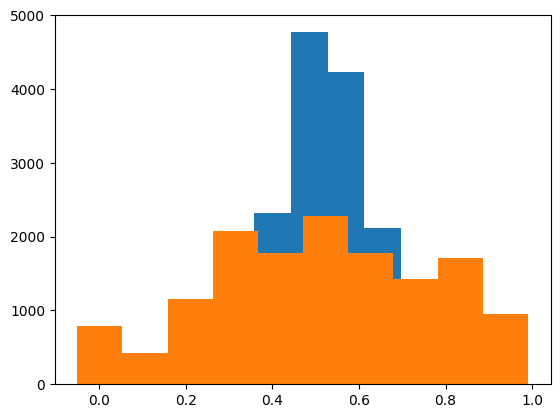

In [141]:
plt.hist(oof_pred.data[:, 0])
plt.hist(tr_data['target'])

(array([3188., 1997., 1465.,  771., 1073., 1136., 1171., 1163., 1191.,
        1146.]),
 array([0.22 , 0.298, 0.376, 0.454, 0.532, 0.61 , 0.688, 0.766, 0.844,
        0.922, 1.   ]),
 <BarContainer object of 10 artists>)

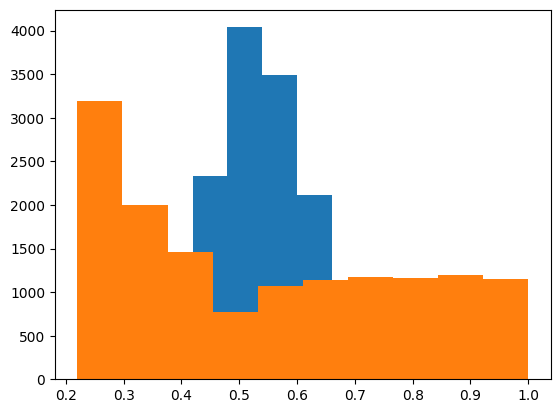

In [62]:
plt.hist(oof_pred.data[:, 0])
plt.hist(tr_data['target'])

In [49]:
tr_data['log_target']

9161     0.588
676      0.323
14458    0.262
10330    0.324
8387     0.255
         ...  
11284    0.265
11964    0.424
5390     0.390
860      0.261
15795    0.434
Name: log_target, Length: 15036, dtype: float64

0.047127061400836744


In [224]:
from sklearn.metrics import mean_squared_error
y_true = te_data.target  # Истинные значения (целевой столбец)
y_pred = automl.predict(te_data).data[:, 0]  # Предсказания

# Вычисляем MAPE
mape = mean_squared_error(y_true, y_pred)
print(mape)

0.04892220999080818


In [71]:
type(automl.predict(te_data))

lightautoml.dataset.np_pd_dataset.NumpyDataset

In [105]:
te_data['target']

16144    0.857143
13661    0.750000
344      0.586111
1034     0.500000
8109     0.383333
           ...   
4026     0.875000
15742    0.564286
7571     0.614035
2091     0.850000
14817    0.170000
Name: target, Length: 4790, dtype: float64

In [106]:
y_pred

array([0.67185605, 0.7273166 , 0.6104079 , ..., 0.57287234, 0.5243057 ,
       0.454977  ], dtype=float32)